# 0408 Xgboost Prediction with K-means and DBSCAN

> **ADJUSTABLE PARAMETER**
- FRACTION_SELECTED

> **FUNCTIONS**
- def `split_data`(clustered_name, targer_feature, test_size, random_state)
- def `hyperparameter_tuning`(cv, n_jobs, X_train, y_train)
- def `train_model`(max_depth, learning_rate, n_estimators, X_train, y_train, X_test, y_test)
- def `cross_validation`(model, X_train, y_train, cv)
- def `check_overfitting`(model, X_train, y_train, X_test, y_test)

### Import packages

In [80]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

### Import the data

In [81]:
dbscan_data = pd.read_csv('Xinyi_clustering_DBSCAN.csv')
kmeans_data = pd.read_csv('Xinyi_clustering_K-means.csv')
hierarchical_data = pd.read_csv('Xinyi_clustering_hierarchical.csv')

### Set the fraction percentage and select the used data

In [82]:
FRACTION_SELECTED = 0.2

In [83]:
# Randonly select 10% of the data for each clustering method
dbscan = dbscan_data.sample(frac=FRACTION_SELECTED)
kmeans = kmeans_data.sample(frac=FRACTION_SELECTED)
hierarchical = hierarchical_data.sample(frac=FRACTION_SELECTED)

### Split the data into training and testing sets

In [84]:
# Function to split the data into training and testing sets
def split_data(clustered_name, targer_feature, test_size, random_state):
    X = clustered_name.drop([targer_feature], axis=1)
    y = clustered_name[targer_feature]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [85]:
# DBSCAN
X_train_dbscan, X_test_dbscan, y_train_dbscan, y_test_dbscan = split_data(dbscan, '總價元', 0.2, 42)

# K-means
X_train_kmeans, X_test_kmeans, y_train_kmeans, y_test_kmeans = split_data(kmeans, '總價元', 0.2, 42)

# Hierarchical
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical = split_data(hierarchical, '總價元', 0.2, 42)

### Hyperparameter Tuning for XGBoost

In [86]:
# Function for hyperparameter tuning
def hyperparameter_tuning(cv, n_jobs, X_train, y_train):
    model_dbscan = xgb.XGBRegressor()
    param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300]
    }
    grid_search = GridSearchCV(model_dbscan, param_grid, cv=cv, n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

In [87]:
# DBSCAN
best_params_dbscan = hyperparameter_tuning(5, -1, X_train_dbscan, y_train_dbscan)

# K-means
best_params_kmeans = hyperparameter_tuning(5, -1, X_train_kmeans, y_train_kmeans)

# Hierarchical
best_params_hierarchical = hyperparameter_tuning(5, -1, X_train_hierarchical, y_train_hierarchical)

In [88]:
print('DBSCAN:', best_params_dbscan)
print('K-means:', best_params_kmeans)
print('Hierarchical:', best_params_hierarchical)

DBSCAN: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
K-means: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Hierarchical: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


### Train the model

In [89]:
# Function to train the model
def train_model(max_depth, learning_rate, n_estimators, X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    accuracy = model.score(X_test, y_test)
    return mse, r2, accuracy, model

In [93]:
# DBSCAN
mse_dbscan, r2_dbscan, accuracy_dbscan, model_dbscan = train_model(best_params_dbscan['max_depth'], best_params_dbscan['learning_rate'], best_params_dbscan['n_estimators'], X_train_dbscan, y_train_dbscan, X_test_dbscan, y_test_dbscan)
print('DBSCAN')
print('MSE:', mse_dbscan)
print('R2:', r2_dbscan)
print('Accuracy:', accuracy_dbscan)
print("="*20)

# K-means
mse_kmeans, r2_kmeans, accuracy_kmeans, model_kmeans = train_model(best_params_kmeans['max_depth'], best_params_kmeans['learning_rate'], best_params_kmeans['n_estimators'], X_train_kmeans, y_train_kmeans, X_test_kmeans, y_test_kmeans)
print('K-means')
print('MSE:', mse_kmeans)
print('R2:', r2_kmeans)
print('Accuracy:', accuracy_kmeans)
print("="*20)

# Hierarchical
mse_hierarchical, r2_hierarchical, accuracy_hierarchical, model_hierarchical = train_model(best_params_hierarchical['max_depth'], best_params_hierarchical['learning_rate'], best_params_hierarchical['n_estimators'], X_train_hierarchical, y_train_hierarchical, X_test_hierarchical, y_test_hierarchical)
print('Hierarchical')
print('MSE:', mse_hierarchical)
print('R2:', r2_hierarchical)
print('Accuracy:', accuracy_hierarchical)

DBSCAN
MSE: 176949797982483.88
R2: 0.8637936217613601
Accuracy: 0.8637936217613601
K-means
MSE: 438737744932844.6
R2: 0.6141132786227572
Accuracy: 0.6141132786227572
Hierarchical
MSE: 575345619432680.2
R2: 0.854806244184053
Accuracy: 0.854806244184053


### Feature Importance

In [103]:
# Function to plot the feature importance
def plot_feature_importance(model, num_features, importance_type, colour, title):
    plot_importance(model, max_num_features=num_features, importance_type=importance_type)
    plt.grid(False)
    for bar in plt.gca().patches:
        bar.set_facecolor(colour)
    plt.title(title)
    plt.show()

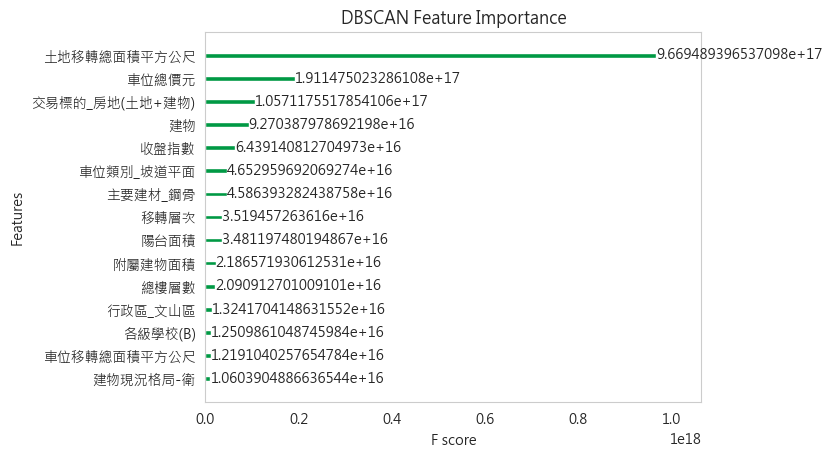

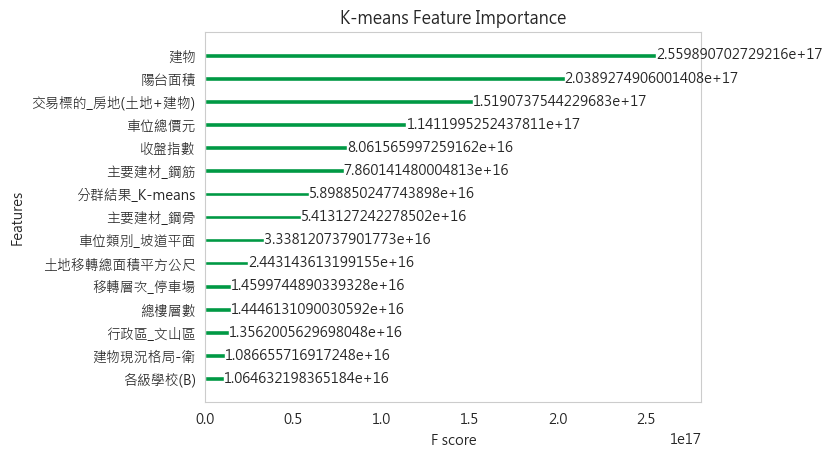

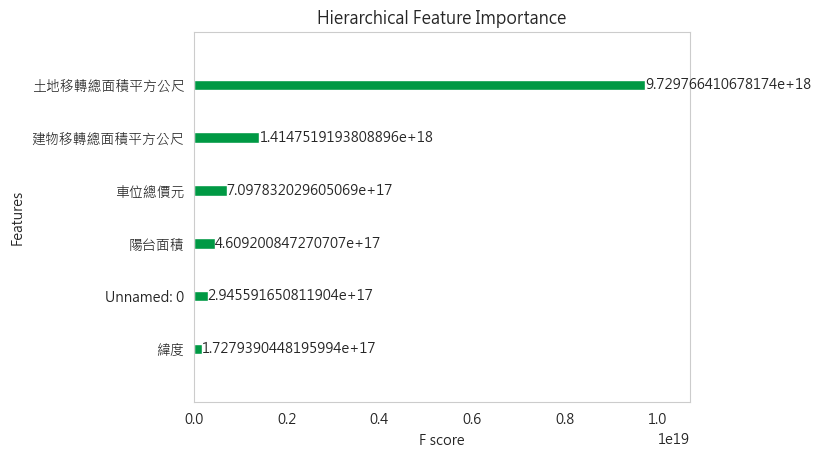

In [104]:
# DBSCAN
plot_feature_importance(model_dbscan, 15, 'gain', '#009944ff', 'DBSCAN Feature Importance')

# K-means
plot_feature_importance(model_kmeans, 15, 'gain', '#009944ff', 'K-means Feature Importance')

# Hierarchical
plot_feature_importance(model_hierarchical, 15, 'gain', '#009944ff', 'Hierarchical Feature Importance')

### Cross Validation

In [107]:
# Function for cross validation
def cross_validation(model, X_train, y_train, cv):
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    return scores

In [111]:
# DBSCAN
cv_dbscan = cross_validation(model_dbscan, X_train_dbscan, y_train_dbscan, 5)
print('DBSCAN')
print('Cross Validation:', cv_dbscan)
print('Mean:', np.mean(cv_dbscan))
print("="*40)

# K-means
cv_kmeans = cross_validation(model_kmeans, X_train_kmeans, y_train_kmeans, 5)
print('K-means')
print('Cross Validation:', cv_kmeans)
print('Mean:', np.mean(cv_kmeans))
print("="*40)

# Hierarchical
cv_hierarchical = cross_validation(model_hierarchical, X_train_hierarchical, y_train_hierarchical, 5)
print('Hierarchical')
print('Cross Validation:', cv_hierarchical)
print('Mean:', np.mean(cv_hierarchical))

DBSCAN
Cross Validation: [0.95364024 0.7998192  0.88782222 0.72090062 0.62886402]
Mean: 0.798209258563323
K-means
Cross Validation: [0.53097294 0.60892168 0.69373996 0.76198565 0.7791222 ]
Mean: 0.674948488252759
Hierarchical
Cross Validation: [0.50613938 0.55235814 0.53087964 0.66100913 0.36539438]
Mean: 0.523156134429622


### Overfitting check

In [113]:
# Function to check if the model is overfitting
def check_overfitting(model, X_train, y_train, X_test, y_test):
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    return train_score, test_score

In [114]:
# DBSCAN
train_score_dbscan, test_score_dbscan = check_overfitting(model_dbscan, X_train_dbscan, y_train_dbscan, X_test_dbscan, y_test_dbscan)
print('DBSCAN')
print('Train Score:', train_score_dbscan)
print('Test Score:', test_score_dbscan)
print("="*20)

# K-means
train_score_kmeans, test_score_kmeans = check_overfitting(model_kmeans, X_train_kmeans, y_train_kmeans, X_test_kmeans, y_test_kmeans)
print('K-means')
print('Train Score:', train_score_kmeans)
print('Test Score:', test_score_kmeans)
print("="*20)

# Hierarchical
train_score_hierarchical, test_score_hierarchical = check_overfitting(model_hierarchical, X_train_hierarchical, y_train_hierarchical, X_test_hierarchical, y_test_hierarchical)
print('Hierarchical')
print('Train Score:', train_score_hierarchical)
print('Test Score:', test_score_hierarchical)


DBSCAN
Train Score: 0.9956376281926689
Test Score: 0.8637936217613601
K-means
Train Score: 0.9796538331813894
Test Score: 0.6141132786227572
Hierarchical
Train Score: 0.6497120814800896
Test Score: 0.854806244184053
